In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup constant head boundary with two observations

In [6]:
from morpheus.project.types.boundaries.Observation import ObservationName
from morpheus.project.types.boundaries.RiverObservation import ObservationId, Conductance, RiverObservationValue, RiverStage, \
  RiverbedBottom, RiverObservation
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection, RiverBoundary
from morpheus.project.types.layers import LayerId

layers_list = [LayerId.new()]

river_boundary = RiverBoundary.from_geometry(
  name=BoundaryName('river'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92499, 50.966),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    RiverObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          riverbed_bottom=RiverbedBottom.from_float(100),
          river_stage=RiverStage.from_float(105),
          conductance=Conductance.from_float(50),
        ),
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          riverbed_bottom=RiverbedBottom.from_float(100),
          river_stage=RiverStage.from_float(105),
          conductance=Conductance.from_float(50),
        ),
      ]
    ),
    RiverObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96401)),
      data=[
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          riverbed_bottom=RiverbedBottom.from_float(95),
          river_stage=RiverStage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          riverbed_bottom=RiverbedBottom.from_float(95),
          river_stage=RiverStage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(river_boundary)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(river_boundary.as_geojson()))
for observation in river_boundary.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.fit_bounds(m.get_bounds())
m

In [7]:
river_boundary.observations

[RiverObservation(observation_id=ObservationId(value='5ac59c01-2cd2-485d-bbc7-b09712d8b16c'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), data=[RiverObservationValue(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), river_stage=RiverStage(value=105), riverbed_bottom=RiverbedBottom(value=100), conductance=Conductance(value=50)), RiverObservationValue(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)), river_stage=RiverStage(value=105), riverbed_bottom=RiverbedBottom(value=100), conductance=Conductance(value=50))]),
 RiverObservation(observation_id=ObservationId(value='04baf3fd-28fe-4c03-9adc-c36beb04f583'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92004, 50.96401), type='Point'), data=[RiverObservationValue(date_time=StartDateTime(value=datetime.datetime(2019, 

In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.RivPackageMapper import \
  calculate_riv_boundary_stress_period_data

result = calculate_riv_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  riv_boundary=river_boundary,
)
result.to_dict()

{0: [[0, 49, 0, 100.0, 100.0, 95.0],
  [0, 49, 1, 100.03393064024003, 99.6606935975997, 95.03393064024003],
  [0, 48, 2, 100.09139229956574, 99.08607700434257, 95.09139229956574],
  [0, 49, 2, 100.07740874835528, 99.22591251644711, 95.07740874835528],
  [0, 48, 3, 100.13487040767791, 98.65129592322087, 95.13487040767791],
  [0, 47, 4, 100.19233205496651, 98.07667945033482, 95.19233205496651],
  [0, 48, 4, 100.17834851579318, 98.21651484206829, 95.17834851579318],
  [0, 47, 5, 100.23581016307868, 97.64189836921312, 95.23581016307868],
  [0, 46, 6, 100.29327179832119, 97.0672820167881, 95.29327179832119],
  [0, 47, 6, 100.2792882711924, 97.20711728807598, 95.2792882711924],
  [0, 46, 7, 100.33674990643645, 96.63250093563552, 95.33674990643645],
  [0, 45, 8, 100.3942115296403, 96.05788470359701, 95.3942115296403],
  [0, 46, 8, 100.38022801454862, 96.19771985451382, 95.38022801454862],
  [0, 45, 9, 100.43768963775555, 95.62310362244442, 95.43768963775555],
  [0, 44, 10, 100.49515124891734,

## Calculate

In [9]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType

calculation = CalculationService.calculate(model=model, profile=CalculationProfile.new(CalculationEngineType.MF2005))

FloPy is using the following executable to run the model: ../../../../../../Users/ralf/Projects/inowas/morpheus/src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/08/19 12:16:36

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/08/19 12:16:36
 Elapsed run time:  0.034 Seconds

  Normal termination of simulation


In [10]:
calculation.check_model_log

Log(log=['type,package,k,i,j,value,desc'])

In [11]:
calculation.calculation_result

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['mf2005.list', 'mf2005.dis', 'mf2005.nam', 'mf2005.bas', 'mf2005.lpf', 'mf2005.pcg', 'mf2005.riv', 'mf2005.oc', 'mf2005.hds'], flow_head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0, min_value=100.00115203857422, max_value=104.97737121582031), flow_drawdown_results=None, flow_budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0, min_value=None, max_value=None), transport_concentration_results=None, transport_budget_results=None, packages=['DIS', 'BAS6', 'RIV', 'PCG', 'LPF', 'OC'])

In [12]:
head = calculation.read_flow_head(idx=0, layer=0)

In [13]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[101.82599639892578, 101.82679748535156, 101.82839965820312, 101.83080291748047, 101.83399963378906, 101.83799743652344, 101.84269714355469, 101.84829711914062, 101.85459899902344, 101.86180114746094, 101.86969757080078, 101.87840270996094, 101.88790130615234, 101.89820098876953, 101.9092025756836, 101.9209976196289, 101.93360137939453, 101.9468994140625, 101.96099853515625, 101.97589874267578, 101.99150085449219, 102.00779724121094, 102.02490234375, 102.04280090332031, 102.0613021850586, 102.08059692382812, 102.10060119628906, 102.12129974365234, 102.1427001953125, 102.16480255126953, 102.18769836425781, 102.21119689941406, 102.23539733886719, 102.26020050048828, 102.28579711914062, 102.31199645996094, 102.33879852294922, 102.36630249023438, 102.39440155029297, 102.42320251464844, 102.45259857177734, 102.48269653320312, 102.51329803466797, 102.54450225830078, 102.57640075683594, 102.60880279541016, 102.64179992675781, 102.67539978027344, 102.70960235595703, 102.74430084228516, 102.7

In [14]:
calculation.read_flow_drawdown(idx=0, layer=0)

[]

In [15]:
calculation.read_flow_budget(idx=0, incremental=False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'RIVER_LEAKAGE_IN': 877.0484,
 'TOTAL_IN': 877.0484,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'RIVER_LEAKAGE_OUT': -877.0629,
 'TOTAL_OUT': -877.0629,
 'IN-OUT': -0.014465,
 'PERCENT_DISCREPANCY': -0.0,
 'tslen': 365.0}

In [16]:
calculation.read_flow_budget(idx=0, incremental=True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'RIVER_LEAKAGE_IN': 2.4029,
 'TOTAL_IN': 2.4029,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'RIVER_LEAKAGE_OUT': -2.4029,
 'TOTAL_OUT': -2.4029,
 'IN-OUT': -3.9577e-05,
 'PERCENT_DISCREPANCY': -0.0,
 'tslen': 365.0}

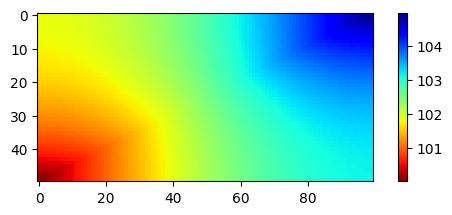

In [17]:
import matplotlib.pyplot as plt

heads = calculation.read_flow_head(idx=0, layer=0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()